# Solving a costum constrained problem with BayeSQP


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from botorch.test_functions.base import ConstrainedBaseTestProblem

from bayesqp import BayeSQP, seed_everything, print_current_defaults

%matplotlib inline

In [2]:
# The following test function was designed with Claude


class MultiMinimaToyProblemCircle(ConstrainedBaseTestProblem):
    r"""Extended quadratic test function with multiple minima."""

    dim = 2
    num_constraints = 2
    _check_grad_at_opt = False
    _bounds = [(0.0, 4.0), (1.0, 6.0)]  # Bounds for the two dimensions

    def __init__(self, circle_center=[2, 3], circle_radius=1, noise_std=None):
        self.continuous_inds = list(range(self.dim))
        super().__init__(noise_std=noise_std)
        self.circle_center = np.array(circle_center)
        self.circle_radius = np.array(circle_radius)

    def _evaluate_true(self, X: torch.Tensor) -> torch.Tensor:
        """Objective function evaluation with multiple minima."""
        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()  # Ensure correct conversion

        # Original quadratic term
        quadratic1 = (X[..., 0] - 3) ** 2 + (X[..., 1] - 2) ** 2

        # Additional quadratic terms to create multiple minima
        quadratic2 = 0.8 * ((X[..., 0] - 1) ** 2 + (X[..., 1] - 4) ** 2)
        quadratic3 = 1.2 * ((X[..., 0] - 2.5) ** 2 + (X[..., 1] - 4.5) ** 2)

        # Combine with a mixture function
        mixture = np.minimum(np.minimum(quadratic1, quadratic2), quadratic3)

        # Add sinusoidal perturbations to create more complex landscape
        perturbation1 = 0.1 * np.sin(5 * X[..., 0] + 3 * X[..., 1])
        perturbation2 = 0.15 * np.cos(3 * X[..., 0] - 2 * X[..., 1])

        # Combine everything
        result = mixture + perturbation1 + perturbation2

        # Add a terrain-like pattern for additional local minima
        terrain = 0.05 * np.sin(8 * X[..., 0]) * np.sin(8 * X[..., 1])

        return torch.tensor(result + terrain)

    def _evaluate_slack_true(self, X: torch.Tensor) -> torch.Tensor:
        """Evaluate constraint slack values."""
        if isinstance(X, torch.Tensor):
            X = X.detach().numpy()

        # Constraint 1: circle_radius - sqrt((x[0] - circle_center[0])^2 + (x[1] - circle_center[1])^2) >= 0
        c1 = self.circle_radius - np.sqrt(
            (X[..., 0] - self.circle_center[0]) ** 2
            + (X[..., 1] - self.circle_center[1]) ** 2
        )

        # Constraint 2: Linear constraint x[0] + x[1] - 5 >= 0
        c2 = X[..., 0] + X[..., 1] - 5

        return torch.tensor([c1, c2])

In [3]:
print_current_defaults()  # show current default settings

 BayeSQP Default Configurations

[General Settings (general_config)]
  tol: 0.0001
  n_initial: 5
  clamp_to_bounds: True
  generate_local_samples_after_step: True
  K: auto
  epsilon: 0.05
  local_sample_strategy: sobol_sphere
  delta_f: 0.2
  delta_c: 0.2
  N_max: None
  use_resets: False
  use_best_from_line_search: True

[Line Search Settings (line_search_config)]
  min_alpha: 0.0
  max_alpha: 1.0
  method: posterior_sampling
  n_candidates: 100
  M: 3
  log_scale: False

[Model Settings (model_config)]
  kernel:
    type: 'D_scaled_prior'
    lengthscale_hyperprior: None
    outputscale_hyperprior: None
    outputscale_constraint: None
    provided_kernel: None
  noise_constraint: Interval[1.0e-06, 1.0e-01]
  noise_hyperprior: None
  prior_mean: 0.0



In [4]:
func = MultiMinimaToyProblemCircle()
DIM = func.dim

# you can overwrite any of the default settings like this
general_config = {
    "tol": 1e-4,
    "local_sample_strategy": "sobol_sphere",
    "clamp_to_bounds": True,  # enforce bounds at all times
    "generate_local_samples_after_step": True,
    "K": 1,  # "auto",  # auto: (DIM+1), int
    "n_initial": DIM,  # initial samples
    "delta_f": 0.2,
    "delta_c": 0.2,
    "epsilon": 0.05,  # sampling radius for local subsamples samples
}

line_search_config = {
    "min_alpha": 0.0,
    "max_alpha": 1.0,
    "method": "posterior_sampling",
    "n_candidates": 100,
    "M": 3,
}

bayesqp = BayeSQP(
    objective_function=func,
    verbose_level=-1,  # -1: silent, 0: normal 1: normal + warnings, 2: debug
    general_config=general_config,
    line_search_config=line_search_config,
)

# this would also work:
# bayesqp = BayeSQP(objective_function=func)

# so would this:
# bayesqp = BayeSQP(
#     objective_function=func,
#     verbose_level=-1,
#     general_config={"n_initial": DIM, "tol": 1e-4},
# )

In [5]:
seed_everything(42)

# Define starting point
bounds = func.bounds
x0 = bounds[0] + torch.rand(DIM).reshape(1, -1) * (bounds[1] - bounds[0])

# Run optimization
result = bayesqp.minimize(x0, max_evals=50)

In [6]:
print(result)

BayeSQP Optimization Result

Optimization Status:
  Feasible:        ✓ Yes
  Function Evals:  50

Best Solution:
  Objective Value: -4.020483e-02
  Solution (x):    [1.3235, 3.7345]
  Best solution obtained at eval #17

Total Time: 10.3638 seconds


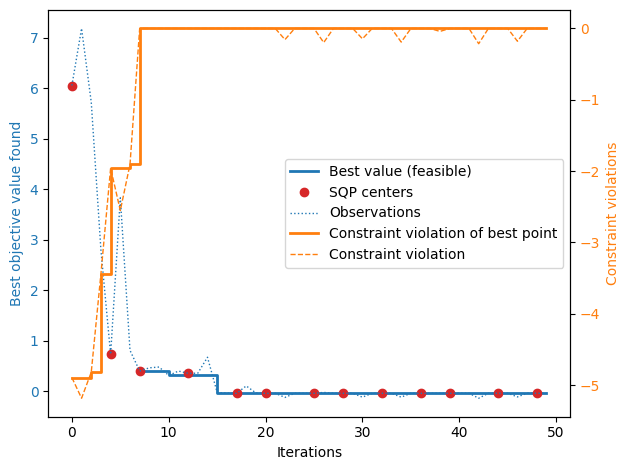

In [7]:
history = result.fun_history
x_history = result.x_history
step_x_history = result.step_history
is_feasible_history = result.feasible_history
constraint_values = np.array(result.constraint_values)

step_counter = 0
step_indieces = []

for i in range(len(x_history)):
    if np.allclose(x_history[i], step_x_history[step_counter]):
        step_indieces.append(i)
        step_counter += 1
        if step_counter >= len(step_x_history):
            break


fig, ax1 = plt.subplots()

# --- Primary axis (objective values)
n_evals = np.arange(0, len(history))
best_feasible_values = np.full_like(history, np.inf)
current_best = np.inf
for i in range(len(history)):
    if is_feasible_history[i] and history[i] < current_best:
        current_best = history[i]
    best_feasible_values[i] = current_best

best_values = best_feasible_values
ax1.step(
    n_evals,
    best_values,
    color="tab:blue",
    lw=2,
    where="post",
    label="Best value (feasible)",
)

ax1.plot(
    n_evals[step_indieces],
    history[step_indieces],
    color="tab:red",
    linestyle="None",
    marker="o",
    label="SQP centers",
)
ax1.plot(
    n_evals,
    history,
    color="tab:blue",
    linestyle="dotted",
    lw=1,
    label="Observations",
)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Best objective value found", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# --- Secondary axis (constraint violations)
ax2 = ax1.twinx()
constraint_values = np.minimum(constraint_values, 0)

# best feasible constraint violation per iteration
constraint_violations = np.sum(constraint_values, axis=1)
best_constraint_violations = np.maximum.accumulate(constraint_violations)

ax2.step(
    n_evals,
    best_constraint_violations,
    color="tab:orange",
    lw=2,
    where="post",
    label="Constraint violation of best point",
)
ax2.plot(
    n_evals,
    constraint_violations,
    color="tab:orange",
    lw=1,
    linestyle="dashed",
    label="Constraint violation",
)
ax2.set_ylabel("Constraint violations", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# --- Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.tight_layout()
plt.show()

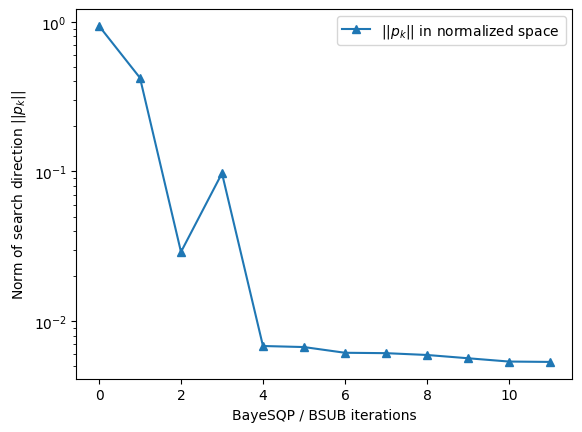

In [8]:
directions = result.info.directions

# p_ts from the unit hypercube
normalized_directions = result.info.normalized_directions
norm_norm_pk = np.linalg.norm(normalized_directions, axis=1)
plt.plot(
    np.arange(len(norm_norm_pk)),
    norm_norm_pk,
    marker="^",
    color="tab:blue",
    label="$||p_k||$ in normalized space",
)
plt.legend()
plt.xlabel("BayeSQP / BSUB iterations")
plt.yscale("log")
plt.ylabel("Norm of search direction $||p_k||$")
plt.show()

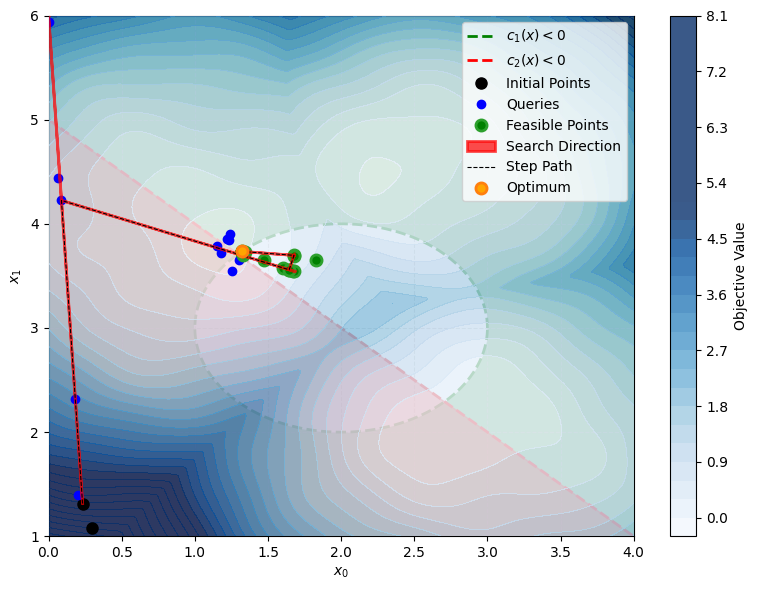

In [9]:
circle_center = func.circle_center
circle_radius = func.circle_radius
n_initial = result.info.n_initial

opt_solution = result.x


# Plot optimization path with contours
x_vals = np.linspace(0, 4, 200)
y_vals = np.linspace(1, 6, 200)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array(
    [
        func.evaluate_true(torch.tensor([xi, yi])).detach()
        for xi, yi in zip(np.ravel(X), np.ravel(Y))
    ]
).reshape(X.shape)


# Second plot: Zoomed view with direction arrows
plt.figure(figsize=(8, 6))

# Constraint 1: Nonlinear constraint (circle)
theta = np.linspace(0, 2 * np.pi, 300)
x_circle = circle_center[0] + circle_radius * np.cos(theta)
y_circle = circle_center[1] + circle_radius * np.sin(theta)
plt.plot(x_circle, y_circle, "g--", linewidth=2, label="$c_1(x) < 0$")

# Constraint 2: Linear constraint x[0] + x[1] >= 4
x_linear = np.linspace(0, 4, 100)
y_linear = 5 - x_linear
plt.plot(x_linear, y_linear, "r--", linewidth=2, label="$c_2(x) < 0$")

# Define domain limits
x_min, x_max = 0, 4
y_min, y_max = 1, 6

# Shade infeasible region for circle constraint (outside circle)
rect_x = [x_min, x_max, x_max, x_min, x_min]
rect_y = [y_min, y_min, y_max, y_max, y_min]
plt.fill(rect_x, rect_y, color="green", alpha=0.5)
plt.fill(x_circle, y_circle, color="white", alpha=1.0, zorder=1)

# Shade infeasible region for linear constraint
plt.fill_between(
    x_linear,
    y_min,
    y_linear,
    where=(y_linear >= y_min),
    color="red",
    alpha=0.5,
    interpolate=True,
    zorder=2,
)

# Plot contours
contour = plt.contourf(X, Y, Z, levels=30, cmap="Blues", alpha=0.8, vmax=5, zorder=3)

# Plot optimization points
plt.plot(
    x_history[:n_initial, 0],
    x_history[:n_initial, 1],
    "ko",
    markersize=8,
    label="Initial Points",
    zorder=100,
)

plt.plot(
    x_history[n_initial:, 0],
    x_history[n_initial:, 1],
    "bo",
    markersize=6,
    label="Queries",
    zorder=101,
)

# Draw circles around feasible points
feasible_points = x_history[result.feasible_history]
for i, point in enumerate(feasible_points):
    plt.plot(
        point[0],
        point[1],
        "go",
        markersize=8,
        markeredgecolor="tab:green",
        markeredgewidth=2,
        zorder=101 + i,
        label="Feasible Points" if i == 0 else "",
    )


# Plot direction arrows
for i, (point, direction) in enumerate(zip(step_x_history, directions)):
    plt.arrow(
        point[0],
        point[1],
        direction[0],
        direction[1],
        fc="red",
        ec="red",
        alpha=0.7,
        linewidth=2,
        zorder=200 + i,
        label="Search Direction" if i == 0 else "",
    )

# Plot step path
plt.plot(
    step_x_history[:, 0],
    step_x_history[:, 1],
    color="k",
    linestyle="--",
    linewidth=0.8,
    label="Step Path",
    zorder=10000,
)
# Plot optimum
plt.plot(
    opt_solution[0],
    opt_solution[1],
    "o",
    color="orange",
    markersize=8,
    markeredgecolor="tab:orange",
    markeredgewidth=2,
    label="Optimum",
    zorder=200000,
)

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="best")
plt.xlim([0, 4])
plt.ylim([1, 6])
plt.grid(linestyle="--", alpha=0.6)
plt.colorbar(contour, label="Objective Value")
plt.tight_layout()